In [1]:
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import csv
import time
import collections
import random
import timeit
import math

import scipy,sklearn,pylab
from scipy import io

from sklearn import model_selection,covariance
from sklearn.model_selection import train_test_split,KFold
from sklearn.feature_extraction import DictVectorizer

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['figure.figsize'] = (9,8)

In [2]:
def readfile(path, cols):
    with open(path) as csvfile:
        reader = csv.DictReader(csvfile)
        q=list(reader)
    s = [dict(([a,'-1'] if (x=='') else [a,x]) for a,x in b.items()) for b in q]
    return [dict((
        [a,float(x)] if a in cols else [a,x]) for a,x in b.items()) for b in s]

In [3]:
def removeneg(data,n=None):    
    def f(data,n=None):
        a = data[data!=-1]
        if n:
            m=n
        else:
            m = np.median(a)
        for i in range(len(data)):
            if (data==-1)[i]:
                data[i]=m
        return m
    l = []
    if n:
        for i in range(data.shape[1]):
            f(data[:,i],n[i])
    else:
         for i in range(data.shape[1]):
            l.append(f(data[:,i]))
    return l

In [4]:
s = readfile("hw5_titanic_dist/titanic_training.csv",[
    'pclass','age','sibsp','parch','fare'])

titanic_labels = np.array([z.pop('survived') for z in s]).astype(
    float).astype(int)
r = readfile("hw5_titanic_dist/titanic_testing_data.csv",[
    'pclass','age','sibsp','parch','fare'])

t = s+r

v= sklearn.feature_extraction.DictVectorizer(sparse=False,sort=False)
titanic_hot = v.fit_transform(t)
titanic_hot_train = titanic_hot[:1000,:]
titanic_test = titanic_hot[1000:,:]

titanic_feat_names = v.get_feature_names()

In [5]:
t_medians = removeneg(titanic_hot_train)
removeneg(titanic_test,t_medians)
#titanic_hot_train

[]

In [6]:
#v.inverse_transform(titanic_hot_train)

In [7]:
spam= scipy.io.loadmat("hw5_spam_dist/dist/spam_data")
#spam

In [8]:
spam_train = spam['training_data']
spam_labels = spam['training_labels'][0]
spam_test = spam['test_data']

In [9]:
s= readfile("hw5_census_dist/train_data.csv",[
    'capital-gain','capital-loss','age','hours-per-week',
    'education-num','fnlwgt'])
census_labels = np.array([z.pop('label') for z in s]).astype(int)
r = readfile("hw5_census_dist/test_data.csv",[
    'capital-gain','capital-loss','age','hours-per-week',
    'education-num','fnlwgt'])

t=s+r
v= sklearn.feature_extraction.DictVectorizer(sparse=False,sort=False)
census_hot = v.fit_transform(t)
census_hot_train = census_hot[:32724,:]
census_test = census_hot[32724:,:]

census_feat_names = v.get_feature_names()


In [10]:
#c_medians = removeneg(census_hot_train)
#census_hot_train

In [11]:
#v.inverse_transform(census_hot_train)

In [12]:
class DecisionTree:
    def __init__(self,features,featureNames=None,n=None):
        self.features = features
        self.n = n
        if featureNames:
            self.featureNames = featureNames
        else:
            self.featureNames = features
    def select_features(self):        
        if self.n:
            return random.sample(self.features,self.n)  
        else:
            return self.features
    def sort(self,S,by):
        return [S[i] for i in np.argsort(self.data[S,by])]
    def train(self,data,labels,depth=-1):
        self.data = data
        self.labels = labels
        self.tree = self.make_tree(data,labels,depth)
    def findleaf(self,point,node,v=False):
        if node.isLeaf:
            return node.cat
        if point[node.split_feat]<node.split_val:
            if v:
                print("\'"+str(self.featureNames[node.split_feat])+
                      '\'<'+str(node.split_val))
            return self.findleaf(point,node.left,v)
        else:
            if v:
                print("\'"+str(self.featureNames[node.split_feat])+
                      '\'>='+str(node.split_val))
            return self.findleaf(point,node.right,v)
    def predict(self,data):
        return np.apply_along_axis(self.findleaf,1,data,self.tree)
    def score(self,v,lab):
        return 1-np.count_nonzero(lab-self.predict(v))/lab.shape[0]
    def make_tree(self,data,labels,depth=-1):
        return self.make_node(list(range(data.shape[0])),depth)
    def bfswalk(self):
        queue = [self.tree]
        while queue :
            nextqueue =[]
            for n in queue:
                print(n, end =" ")
                if not n.isLeaf:
                    nextqueue.append(n.left)
                    nextqueue.append(n.right)
            print("")
            queue=nextqueue
    def walk(self):
        self.dfswalk(self.tree)
    def dfswalk(self,node,depth=0,c=''):
        if node.isLeaf:
            print('|  '*(depth-1)+c+"class:"+str(node.cat))
        else:
            print('|  '*(depth-1)+c+"feat:\'"+
                  str(self.featureNames[node.split_feat]) + '\',val:' +
                  str(node.split_val))
            self.dfswalk(node.left,depth+1,c="<  ")
            self.dfswalk(node.right,depth+1,c=">= ")
    
                
    class Node:
        def __init__(self,S,isLeaf,left=None,right=None,
                     split_feat=None,split_val=None,cat=None):
            self.S = S
            self.left = left
            self.right = right
            self.isLeaf= isLeaf
            self.split_feat = split_feat
            self.split_val = split_val
            self.cat=cat
        def __repr__(self):
            if self.isLeaf:
                return str(self.cat)
            else:
                return str(self.split_feat) + ","+str(self.split_val)        
    def is_pure(self,S):
        return len(set(self.labels[S]))==1
    def xlog(self,x):
        return x*math.log(x) if x > 0 else 0
    
    def entropy(self,left,right):
        new = 0
        for l in left.keys():
            new+=self.xlog(left[l])
        for r in right.keys():
            new+=self.xlog(right[r])
        new -= self.xlog(sum(right.values()))
        new -= self.xlog(sum(left.values()))
        return new
                    
    def make_node(self,S,depth=-1):
        #print("making node with "+str(S))
        if self.is_pure(S) or depth==0: 
            #print("pure node " + str(self.labels[S]))
            return self.Node(S,isLeaf=True,cat=scipy.stats.mode(
                self.labels[S])[0][0])
            
        else:
            diff= 0
            feat = None
            beta = None
            for f in self.select_features():   
                hist = np.unique(self.data[S,f],return_counts=True)
                sl= []
                sr = self.sort(S,by=f)
                sr.reverse()
                propr = collections.Counter(self.labels[S])
                srlen = len(sr)
                sllen = 0
                propl = collections.Counter()
                new = 0
                i=0
                finalsl = sl[:]
                finalsr = sr[:]
                debt = 0
                for val in hist[0][1:]:                   
                    j=hist[1][i]                    
                    l2=[sr.pop() for i in range(j)]
                    sl.extend(l2)
                    sam = collections.Counter(self.labels[l2])                    
                    debt+=j
                    propl2 = propl + sam
                    propr2 = propr - sam
                    for k in sam.keys():    
                        new += self.xlog(propl[k]) -\
                        self.xlog(propl2[k]) +\
                        self.xlog(propr[k]) - \
                        self.xlog(propr2[k])                        
                    propl = propl2
                    propr = propr2                    
                    new += -self.xlog(sllen) +self.xlog(sllen+j) - \
                    self.xlog(srlen) +self.xlog(srlen-j)                   
                    sllen +=j
                    srlen -=j
                    i+=1
                    if new<diff:
                        diff = new
                        beta = val
                        feat = f                                                    
                        l1 = [finalsr.pop() for i in range(debt)]
                        finalsl.extend(l1)
                        finalsl2 = finalsl
                        finalsr2 = finalsr
                        debt =0
            if diff==0: 
                return self.Node(S,isLeaf = True,cat=scipy.stats.mode(
                    self.labels[S])[0][0])
            if depth>0:
                return self.Node(S,isLeaf=False,left=self.make_node(
                finalsl2,depth-1),right = self.make_node(
                finalsr2,depth-1),split_feat=feat,split_val=beta)
            else:
                return self.Node(S,isLeaf=False,left=self.make_node(
                finalsl2),right = self.make_node(
                finalsr2),split_feat=feat,split_val=beta)

In [13]:
class RandomForest:
    def __init__(self,features,featuresNames,n=1):
        self.features = features       
        if featuresNames:
            self.featureNames = featuresNames
        else:
            self.featureNames = features
        self.numtrees = n
    def train(self,data,labels,ss,m,depth=-1):
        self.ensemble = []
        for i in range(self.numtrees):
            datas = np.random.choice(data.shape[0],ss,True)
            d =DecisionTree(self.features,self.featureNames,n=int(m))
            d.train(data[datas],labels[datas],depth)
            self.ensemble.append(d)
    def predictpoint(self,point):
        l = [d.findleaf(point,d.tree) for d in self.ensemble]
        return scipy.stats.mode(l)[0][0]
    def predict(self,data):
        return np.apply_along_axis(self.predictpoint,1,data)
    def score(self,v,lab):
        return 1-np.count_nonzero(lab-self.predict(v))/lab.shape[0]
    def walk(self):
        for d in self.ensemble:
            d.walk()
    
        

In [14]:
kf = KFold(n_splits = 5,shuffle=True)
def j(data,label,names,d=-1):
    tree = DecisionTree(list(range(data.shape[1])),names)
    score = 0
    for train_ind,test_ind in kf.split(data):
        tdata = data[train_ind]
        tlabel = label[train_ind]
        vdata = data[test_ind]
        vlabel = label[test_ind]        
        tree.train(tdata,tlabel,depth=d)
        score += tree.score(vdata,vlabel)

    return score/5

def k(data,label,names,num_trees,d_bag,f_bag,d=-1):
    tree = RandomForest(list(range(data.shape[1])),names,num_trees)
    score = 0
    for train_ind,test_ind in kf.split(data):
        tdata = data[train_ind]
        tlabel = label[train_ind]
        vdata = data[test_ind]
        vlabel = label[test_ind]        
        tree.train(tdata,tlabel,d_bag,f_bag,depth=d)
        score += tree.score(vdata,vlabel)

    return score/5

In [15]:
spam_feat_names = ['pain','private','bank','money','drug','spam',
                   'prescription','creative','height','featured',
                   'differ','width','other','energy','business',
                   'message','volumes','revision','path','meter',
                   'memo','planning','pleased','record','out',';',
                   '$','#','!','(','[','&']

In [16]:
spam_t, spam_v, spam_t_label,spam_v_label=train_test_split(
    spam_train,spam_labels,test_size=0.2)
census_t, census_v, census_t_label, census_v_label = train_test_split(
    census_hot_train,census_labels,test_size = 0.2)
titanic_t, titanic_v, titanic_t_label, titanic_v_label = train_test_split(
    titanic_hot_train,titanic_labels,test_size = 0.2)

In [17]:
spamtree = DecisionTree(list(range(32)),spam_feat_names)
spamforest = RandomForest(list(range(32)),spam_feat_names,10)
spamtree.train(spam_t,spam_t_label)
spamforest.train(spam_t,spam_t_label,spam_t.shape[0],np.sqrt(
    spam_t.shape[1]))

print("Spam Tree test accuracy:",spamtree.score(spam_t,spam_t_label))
print("Spam Tree validation accuracy:",spamtree.score(
    spam_v,spam_v_label))
                                                      
print("Spam Forest test accuracy:",spamforest.score(spam_t,spam_t_label))
print("Spam Forest validation accuracy:",spamforest.score(
    spam_v,spam_v_label))

Spam Tree test accuracy: 0.8532777807077686
Spam Tree validation accuracy: 0.7897068129086691
Spam Forest test accuracy: 0.819418807024946
Spam Forest validation accuracy: 0.7937144062434085


In [18]:
censustree = DecisionTree(list(range(108)),census_feat_names)
censusforest = RandomForest(list(range(108)),census_feat_names,10)
censustree.train(census_t,census_t_label)
censusforest.train(census_t,census_t_label,census_t.shape[0],np.sqrt(
    census_t.shape[1]))

print("Census Tree test accuracy:",censustree.score(
    census_t,census_t_label))
print("Census Tree validation accuracy:",censustree.score(
    census_v,census_v_label))
                                                      
print("Census Forest test accuracy:",censusforest.score(
    census_t,census_t_label))
print("Census Forest validation accuracy:",censusforest.score(
    census_v,census_v_label))

Census Tree test accuracy: 1.0
Census Tree validation accuracy: 0.8108479755538579
Census Forest test accuracy: 0.8914397035792048
Census Forest validation accuracy: 0.8614209320091673


In [19]:
titanictree = DecisionTree(list(range(1129)),titanic_feat_names)
titanicforest = RandomForest(list(range(1129)),titanic_feat_names,10)
titanictree.train(titanic_t,titanic_t_label)
titanicforest.train(titanic_t,titanic_t_label,titanic_t.shape[0],np.sqrt(
    titanic_t.shape[1]))

print("Titanic Tree test accuracy:",titanictree.score(
    titanic_t,titanic_t_label))
print("Titanic Tree validation accuracy:",titanictree.score(
    titanic_v,titanic_v_label))
                                                      
print("Titanic Forest test accuracy:",titanicforest.score(
    titanic_t,titanic_t_label))
print("Titanic Forest validation accuracy:",titanicforest.score(
    titanic_v,titanic_v_label))

Titanic Tree test accuracy: 0.9975
Titanic Tree validation accuracy: 0.8200000000000001
Titanic Forest test accuracy: 0.86125
Titanic Forest validation accuracy: 0.8049999999999999


In [20]:
#for c in [1,2,3,4,5,10,15,20,25,30,40]:
#    print(c,j(spam_train,spam_labels,spam_feat_names,c))

In [21]:
#for k in [50]:
#    print(c,k(spam_train,spam_labels,spam_feat_names,c,spam_train.shape[0],np.sqrt(spam_train.shape[1]),20))

In [22]:
#kaggle
spamforest = RandomForest(list(range(32)),spam_feat_names,50)
spamforest.train(spam_train,spam_labels,spam_train.shape[0],np.sqrt(
    spam_train.shape[1]),depth=20)
censusforest = RandomForest(list(range(108)),census_feat_names,10)
censusforest.train(
    census_hot_train,census_labels,census_hot_train.shape[0],np.sqrt(
    census_hot_train.shape[1]))
titanicforest = RandomForest(list(range(1129)),titanic_feat_names,20)
titanicforest.train(
    titanic_hot_train,titanic_labels,titanic_hot_train.shape[0],7*np.sqrt(
    titanic_hot_train.shape[1]))

In [23]:
def output(self,path,data,zindex=0):
        np.savetxt(
        path, np.column_stack(
        (np.array(
            list(zindex+np.arange(data.shape[0]))),self.predict(
            data))).astype(int), 
        fmt ="%i",delimiter = ",", 
        header = "Id,Category",comments = "")

In [24]:
output(spamforest,"spamkaggle.csv",spam_test,0)

![spam](spamkaggle.PNG)

In [25]:
output(censusforest,"censuskaggle.csv",census_test,1)

![census](censuskaggle.PNG)

In [26]:
output(titanicforest,"titanicforest.csv",titanic_test,1)

![titanic](titanickaggle.PNG)

In [27]:
spamtree2 = DecisionTree(list(range(32)),spam_feat_names)
spamtree2.train(spam_train,spam_labels)
spamforest2 = RandomForest(list(range(32)),spam_feat_names,64)
spamforest2.train(spam_train,spam_labels,spam_train.shape[0],np.sqrt(
    spam_train.shape[1]),depth=1)

In [28]:
#classify spam
spamtree2.findleaf(spam_train[0],spamtree.tree,True)

'!'<1.0
'('<1.0
'meter'<1.0
';'<2.0
'creative'<1.0
'energy'<1.0
'money'<1.0
'pain'<1.0
'$'<1.0
'&'<1.0
'prescription'<1.0
'memo'<1.0
'volumes'<1.0
'['<1.0
'bank'<2.0
'spam'<1.0
'business'<1.0
'private'<1.0
'drug'<1.0
'planning'<1.0
'revision'<1.0
'differ'<1.0
'path'<1.0
'other'<2.0
'message'>=1.0
'#'>=1.0
'out'<2.0
'#'<3.0


1

In [29]:
#classify ham
spamtree2.findleaf(spam_train[-1],spamtree.tree,True)

'!'<1.0
'('>=1.0
'money'<1.0
'featured'<1.0
'energy'<1.0
'$'>=1.0
';'<4.0
'pain'<1.0
'volumes'<1.0
'private'<1.0
'('<2.0
'$'>=2.0
'&'<3.0
'$'<3.0
';'>=1.0
'bank'<3.0
'#'<2.0
'out'<1.0
'message'>=1.0


0

In [30]:
#most often split
c = collections.Counter()
for t in spamforest2.ensemble:
    c[(spamforest2.featureNames[t.tree.split_feat],t.tree.split_val)] +=1
c

Counter({('!', 1.0): 11,
         ('$', 1.0): 1,
         ('&', 1.0): 1,
         ('(', 1.0): 8,
         ('creative', 1.0): 3,
         ('differ', 1.0): 3,
         ('energy', 1.0): 3,
         ('featured', 1.0): 5,
         ('memo', 1.0): 1,
         ('meter', 1.0): 5,
         ('money', 1.0): 12,
         ('prescription', 1.0): 4,
         ('spam', 1.0): 2,
         ('volumes', 1.0): 5})

In [31]:
censustree2 = DecisionTree(list(range(108)),census_feat_names)
censustree2.train(census_t,census_t_label)
censusforest2 = RandomForest(list(range(108)),census_feat_names,216)
censusforest2.train(
    census_hot_train,census_labels,census_hot_train.shape[0],np.sqrt(
    census_hot_train.shape[1]),depth=1)

In [32]:
#classify 1
censustree2.findleaf(census_hot_train[4],censustree.tree,True)

'marital-status=Married-civ-spouse'>=1.0
'education-num'<12.0
'capital-gain'>=5178.0
'age'<61.0
'native-country=United-States'>=1.0


1

In [33]:
#classify 0
censustree2.findleaf(census_hot_train[0],censustree.tree,True)

'marital-status=Married-civ-spouse'<1.0
'capital-gain'<7430.0
'education-num'<13.0
'age'>=34.0
'hours-per-week'>=42.0
'capital-loss'<2444.0
'education-num'<7.0
'fnlwgt'>=50837.0


0

In [34]:
#most often split
c = collections.Counter()
for t in censusforest2.ensemble:
    c[(censusforest2.featureNames[t.tree.split_feat],t.tree.split_val)] +=1
c

Counter({('age', 28.0): 5,
         ('age', 29.0): 9,
         ('capital-gain', 5178.0): 8,
         ('capital-gain', 7262.0): 5,
         ('capital-gain', 7298.0): 1,
         ('capital-loss', 1825.0): 5,
         ('capital-loss', 1848.0): 3,
         ('education-num', 13.0): 14,
         ('education=11th', 1.0): 2,
         ('education=Bachelors', 1.0): 3,
         ('education=Doctorate', 1.0): 1,
         ('education=HS-grad', 1.0): 1,
         ('education=Masters', 1.0): 2,
         ('education=Prof-school', 1.0): 2,
         ('hours-per-week', 41.0): 4,
         ('hours-per-week', 42.0): 5,
         ('hours-per-week', 43.0): 1,
         ('marital-status=Divorced', 1.0): 2,
         ('marital-status=Married-civ-spouse', 1.0): 21,
         ('marital-status=Never-married', 1.0): 18,
         ('native-country=Mexico', 1.0): 1,
         ('occupation=?', 1.0): 2,
         ('occupation=Adm-clerical', 1.0): 1,
         ('occupation=Exec-managerial', 1.0): 11,
         ('occupation=Handler

In [35]:
def g(z):
    censustree = DecisionTree(list(range(108)),census_feat_names)
    censustree.train(census_t,census_t_label,depth = z)
    return censustree.score(census_v,census_v_label)
x = [1,2,3,5,10,15,20,25,30,35,40]
y = [g(z) for z in x]


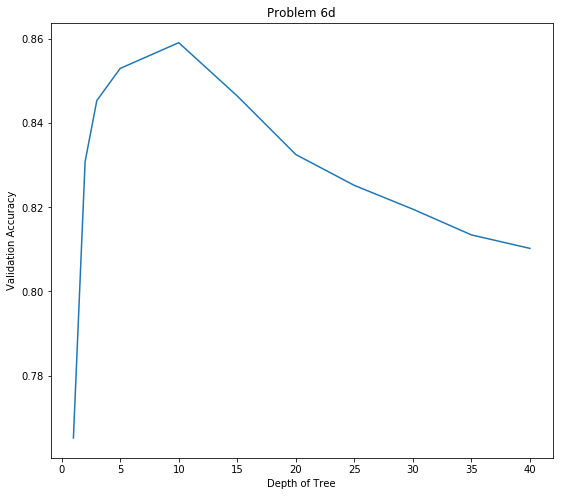

In [40]:
plt.plot(x,y)
plt.title('Problem 6d')
plt.ylabel("Validation Accuracy")
plt.xlabel("Depth of Tree")
plt.show()

In [37]:
#titanic shallow tree
titanictree2 = DecisionTree(list(range(1129)),titanic_feat_names)
titanictree2.train(titanic_hot_train,titanic_labels,3)

In [38]:
titanictree2.walk()

feat:'sex=male',val:1.0
<  feat:'pclass',val:3.0
|  <  feat:'cabin=C22 C26',val:1.0
|  |  <  class:1
|  |  >= class:0
|  >= feat:'fare',val:23.45
|  |  <  class:1
|  |  >= class:0
>= feat:'cabin=-1',val:1.0
|  <  feat:'age',val:18.0
|  |  <  class:1
|  |  >= class:0
|  >= feat:'age',val:4.0
|  |  <  class:1
|  |  >= class:0


In [ ]:

# coding: utf-8

# In[1]:

import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import csv
import time
import collections
import random
import timeit
import math

import scipy,sklearn,pylab
from scipy import io

from sklearn import model_selection,covariance
from sklearn.model_selection import train_test_split,KFold
from sklearn.feature_extraction import DictVectorizer

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['figure.figsize'] = (9,8)


# In[2]:

def readfile(path, cols):
    with open(path) as csvfile:
        reader = csv.DictReader(csvfile)
        q=list(reader)
    s = [dict(([a,'-1'] if (x=='') else [a,x]) for a,x in b.items()) for b in q]
    return [dict((
        [a,float(x)] if a in cols else [a,x]) for a,x in b.items()) for b in s]


# In[3]:

def removeneg(data,n=None):    
    def f(data,n=None):
        a = data[data!=-1]
        if n:
            m=n
        else:
            m = np.median(a)
        for i in range(len(data)):
            if (data==-1)[i]:
                data[i]=m
        return m
    l = []
    if n:
        for i in range(data.shape[1]):
            f(data[:,i],n[i])
    else:
         for i in range(data.shape[1]):
            l.append(f(data[:,i]))
    return l


# In[4]:

s = readfile("hw5_titanic_dist/titanic_training.csv",[
    'pclass','age','sibsp','parch','fare'])

titanic_labels = np.array([z.pop('survived') for z in s]).astype(
    float).astype(int)
r = readfile("hw5_titanic_dist/titanic_testing_data.csv",[
    'pclass','age','sibsp','parch','fare'])

t = s+r

v= sklearn.feature_extraction.DictVectorizer(sparse=False,sort=False)
titanic_hot = v.fit_transform(t)
titanic_hot_train = titanic_hot[:1000,:]
titanic_test = titanic_hot[1000:,:]

titanic_feat_names = v.get_feature_names()


# In[5]:

t_medians = removeneg(titanic_hot_train)
removeneg(titanic_test,t_medians)
#titanic_hot_train


# In[6]:

#v.inverse_transform(titanic_hot_train)


# In[7]:

spam= scipy.io.loadmat("hw5_spam_dist/dist/spam_data")
#spam


# In[8]:

spam_train = spam['training_data']
spam_labels = spam['training_labels'][0]
spam_test = spam['test_data']


# In[9]:

s= readfile("hw5_census_dist/train_data.csv",[
    'capital-gain','capital-loss','age','hours-per-week',
    'education-num','fnlwgt'])
census_labels = np.array([z.pop('label') for z in s]).astype(int)
r = readfile("hw5_census_dist/test_data.csv",[
    'capital-gain','capital-loss','age','hours-per-week',
    'education-num','fnlwgt'])

t=s+r
v= sklearn.feature_extraction.DictVectorizer(sparse=False,sort=False)
census_hot = v.fit_transform(t)
census_hot_train = census_hot[:32724,:]
census_test = census_hot[32724:,:]

census_feat_names = v.get_feature_names()


# In[10]:

#c_medians = removeneg(census_hot_train)
#census_hot_train


# In[11]:

#v.inverse_transform(census_hot_train)


# In[12]:

class DecisionTree:
    def __init__(self,features,featureNames=None,n=None):
        self.features = features
        self.n = n
        if featureNames:
            self.featureNames = featureNames
        else:
            self.featureNames = features
    def select_features(self):        
        if self.n:
            return random.sample(self.features,self.n)  
        else:
            return self.features
    def sort(self,S,by):
        return [S[i] for i in np.argsort(self.data[S,by])]
    def train(self,data,labels,depth=-1):
        self.data = data
        self.labels = labels
        self.tree = self.make_tree(data,labels,depth)
    def findleaf(self,point,node,v=False):
        if node.isLeaf:
            return node.cat
        if point[node.split_feat]<node.split_val:
            if v:
                print("\'"+str(self.featureNames[node.split_feat])+
                      '\'<'+str(node.split_val))
            return self.findleaf(point,node.left,v)
        else:
            if v:
                print("\'"+str(self.featureNames[node.split_feat])+
                      '\'>='+str(node.split_val))
            return self.findleaf(point,node.right,v)
    def predict(self,data):
        return np.apply_along_axis(self.findleaf,1,data,self.tree)
    def score(self,v,lab):
        return 1-np.count_nonzero(lab-self.predict(v))/lab.shape[0]
    def make_tree(self,data,labels,depth=-1):
        return self.make_node(list(range(data.shape[0])),depth)
    def bfswalk(self):
        queue = [self.tree]
        while queue :
            nextqueue =[]
            for n in queue:
                print(n, end =" ")
                if not n.isLeaf:
                    nextqueue.append(n.left)
                    nextqueue.append(n.right)
            print("")
            queue=nextqueue
    def walk(self):
        self.dfswalk(self.tree)
    def dfswalk(self,node,depth=0,c=''):
        if node.isLeaf:
            print('|  '*(depth-1)+c+"class:"+str(node.cat))
        else:
            print('|  '*(depth-1)+c+"feat:\'"+
                  str(self.featureNames[node.split_feat]) + '\',val:' +
                  str(node.split_val))
            self.dfswalk(node.left,depth+1,c="<  ")
            self.dfswalk(node.right,depth+1,c=">= ")
    
                
    class Node:
        def __init__(self,S,isLeaf,left=None,right=None,
                     split_feat=None,split_val=None,cat=None):
            self.S = S
            self.left = left
            self.right = right
            self.isLeaf= isLeaf
            self.split_feat = split_feat
            self.split_val = split_val
            self.cat=cat
        def __repr__(self):
            if self.isLeaf:
                return str(self.cat)
            else:
                return str(self.split_feat) + ","+str(self.split_val)        
    def is_pure(self,S):
        return len(set(self.labels[S]))==1
    def xlog(self,x):
        return x*math.log(x) if x > 0 else 0
    
    def entropy(self,left,right):
        new = 0
        for l in left.keys():
            new+=self.xlog(left[l])
        for r in right.keys():
            new+=self.xlog(right[r])
        new -= self.xlog(sum(right.values()))
        new -= self.xlog(sum(left.values()))
        return new
                    
    def make_node(self,S,depth=-1):
        #print("making node with "+str(S))
        if self.is_pure(S) or depth==0: 
            #print("pure node " + str(self.labels[S]))
            return self.Node(S,isLeaf=True,cat=scipy.stats.mode(
                self.labels[S])[0][0])
            
        else:
            diff= 0
            feat = None
            beta = None
            for f in self.select_features():   
                hist = np.unique(self.data[S,f],return_counts=True)
                sl= []
                sr = self.sort(S,by=f)
                sr.reverse()
                propr = collections.Counter(self.labels[S])
                srlen = len(sr)
                sllen = 0
                propl = collections.Counter()
                new = 0
                i=0
                finalsl = sl[:]
                finalsr = sr[:]
                debt = 0
                for val in hist[0][1:]:                   
                    j=hist[1][i]                    
                    l2=[sr.pop() for i in range(j)]
                    sl.extend(l2)
                    sam = collections.Counter(self.labels[l2])                    
                    debt+=j
                    propl2 = propl + sam
                    propr2 = propr - sam
                    for k in sam.keys():    
                        new += self.xlog(propl[k]) -                        
                        self.xlog(propl2[k]) +                        
                        self.xlog(propr[k]) -                         
                        self.xlog(propr2[k])                        
                    propl = propl2
                    propr = propr2                    
                    new += -self.xlog(sllen) +self.xlog(sllen+j) -                     
                    self.xlog(srlen) +self.xlog(srlen-j)                   
                    sllen +=j
                    srlen -=j
                    i+=1
                    if new<diff:
                        diff = new
                        beta = val
                        feat = f                                                    
                        l1 = [finalsr.pop() for i in range(debt)]
                        finalsl.extend(l1)
                        finalsl2 = finalsl
                        finalsr2 = finalsr
                        debt =0
            if diff==0: 
                return self.Node(S,isLeaf = True,cat=scipy.stats.mode(
                    self.labels[S])[0][0])
            if depth>0:
                return self.Node(S,isLeaf=False,left=self.make_node(
                finalsl2,depth-1),right = self.make_node(
                finalsr2,depth-1),split_feat=feat,split_val=beta)
            else:
                return self.Node(S,isLeaf=False,left=self.make_node(
                finalsl2),right = self.make_node(
                finalsr2),split_feat=feat,split_val=beta)


# In[13]:

class RandomForest:
    def __init__(self,features,featuresNames,n=1):
        self.features = features       
        if featuresNames:
            self.featureNames = featuresNames
        else:
            self.featureNames = features
        self.numtrees = n
    def train(self,data,labels,ss,m,depth=-1):
        self.ensemble = []
        for i in range(self.numtrees):
            datas = np.random.choice(data.shape[0],ss,True)
            d =DecisionTree(self.features,self.featureNames,n=int(m))
            d.train(data[datas],labels[datas],depth)
            self.ensemble.append(d)
    def predictpoint(self,point):
        l = [d.findleaf(point,d.tree) for d in self.ensemble]
        return scipy.stats.mode(l)[0][0]
    def predict(self,data):
        return np.apply_along_axis(self.predictpoint,1,data)
    def score(self,v,lab):
        return 1-np.count_nonzero(lab-self.predict(v))/lab.shape[0]
    def walk(self):
        for d in self.ensemble:
            d.walk()
    
        


# In[14]:

kf = KFold(n_splits = 5,shuffle=True)
def j(data,label,names,d=-1):
    tree = DecisionTree(list(range(data.shape[1])),names)
    score = 0
    for train_ind,test_ind in kf.split(data):
        tdata = data[train_ind]
        tlabel = label[train_ind]
        vdata = data[test_ind]
        vlabel = label[test_ind]        
        tree.train(tdata,tlabel,depth=d)
        score += tree.score(vdata,vlabel)

    return score/5

def k(data,label,names,num_trees,d_bag,f_bag,d=-1):
    tree = RandomForest(list(range(data.shape[1])),names,num_trees)
    score = 0
    for train_ind,test_ind in kf.split(data):
        tdata = data[train_ind]
        tlabel = label[train_ind]
        vdata = data[test_ind]
        vlabel = label[test_ind]        
        tree.train(tdata,tlabel,d_bag,f_bag,depth=d)
        score += tree.score(vdata,vlabel)

    return score/5


# In[15]:

spam_feat_names = ['pain','private','bank','money','drug','spam',
                   'prescription','creative','height','featured',
                   'differ','width','other','energy','business',
                   'message','volumes','revision','path','meter',
                   'memo','planning','pleased','record','out',';',
                   '$','#','!','(','[','&']


# In[16]:

spam_t, spam_v, spam_t_label,spam_v_label=train_test_split(
    spam_train,spam_labels,test_size=0.2)
census_t, census_v, census_t_label, census_v_label = train_test_split(
    census_hot_train,census_labels,test_size = 0.2)
titanic_t, titanic_v, titanic_t_label, titanic_v_label = train_test_split(
    titanic_hot_train,titanic_labels,test_size = 0.2)


# In[17]:

spamtree = DecisionTree(list(range(32)),spam_feat_names)
spamforest = RandomForest(list(range(32)),spam_feat_names,10)
spamtree.train(spam_t,spam_t_label)
spamforest.train(spam_t,spam_t_label,spam_t.shape[0],np.sqrt(
    spam_t.shape[1]))

print("Spam Tree test accuracy:",spamtree.score(spam_t,spam_t_label))
print("Spam Tree validation accuracy:",spamtree.score(
    spam_v,spam_v_label))
                                                      
print("Spam Forest test accuracy:",spamforest.score(spam_t,spam_t_label))
print("Spam Forest validation accuracy:",spamforest.score(
    spam_v,spam_v_label))


# In[18]:

censustree = DecisionTree(list(range(108)),census_feat_names)
censusforest = RandomForest(list(range(108)),census_feat_names,10)
censustree.train(census_t,census_t_label)
censusforest.train(census_t,census_t_label,census_t.shape[0],np.sqrt(
    census_t.shape[1]))

print("Census Tree test accuracy:",censustree.score(
    census_t,census_t_label))
print("Census Tree validation accuracy:",censustree.score(
    census_v,census_v_label))
                                                      
print("Census Forest test accuracy:",censusforest.score(
    census_t,census_t_label))
print("Census Forest validation accuracy:",censusforest.score(
    census_v,census_v_label))


# In[19]:

titanictree = DecisionTree(list(range(1129)),titanic_feat_names)
titanicforest = RandomForest(list(range(1129)),titanic_feat_names,10)
titanictree.train(titanic_t,titanic_t_label)
titanicforest.train(titanic_t,titanic_t_label,titanic_t.shape[0],np.sqrt(
    titanic_t.shape[1]))

print("Titanic Tree test accuracy:",titanictree.score(
    titanic_t,titanic_t_label))
print("Titanic Tree validation accuracy:",titanictree.score(
    titanic_v,titanic_v_label))
                                                      
print("Titanic Forest test accuracy:",titanicforest.score(
    titanic_t,titanic_t_label))
print("Titanic Forest validation accuracy:",titanicforest.score(
    titanic_v,titanic_v_label))


# In[20]:

#for c in [1,2,3,4,5,10,15,20,25,30,40]:
#    print(c,j(spam_train,spam_labels,spam_feat_names,c))


# In[21]:

#for k in [50]:
#    print(c,k(spam_train,spam_labels,spam_feat_names,c,spam_train.shape[0],np.sqrt(spam_train.shape[1]),20))


# In[22]:

#kaggle
spamforest = RandomForest(list(range(32)),spam_feat_names,50)
spamforest.train(spam_train,spam_labels,spam_train.shape[0],np.sqrt(
    spam_train.shape[1]),depth=20)
censusforest = RandomForest(list(range(108)),census_feat_names,10)
censusforest.train(
    census_hot_train,census_labels,census_hot_train.shape[0],np.sqrt(
    census_hot_train.shape[1]))
titanicforest = RandomForest(list(range(1129)),titanic_feat_names,20)
titanicforest.train(
    titanic_hot_train,titanic_labels,titanic_hot_train.shape[0],7*np.sqrt(
    titanic_hot_train.shape[1]))


# In[23]:

def output(self,path,data,zindex=0):
        np.savetxt(
        path, np.column_stack(
        (np.array(
            list(zindex+np.arange(data.shape[0]))),self.predict(
            data))).astype(int), 
        fmt ="%i",delimiter = ",", 
        header = "Id,Category",comments = "")


# In[24]:

output(spamforest,"spamkaggle.csv",spam_test,0)


# ![spam](spamkaggle.PNG)

# In[25]:

output(censusforest,"censuskaggle.csv",census_test,1)


# ![census](censuskaggle.PNG)

# In[26]:

output(titanicforest,"titanicforest.csv",titanic_test,1)


# ![titanic](titanickaggle.PNG)

# In[27]:

spamtree2 = DecisionTree(list(range(32)),spam_feat_names)
spamtree2.train(spam_train,spam_labels)
spamforest2 = RandomForest(list(range(32)),spam_feat_names,64)
spamforest2.train(spam_train,spam_labels,spam_train.shape[0],np.sqrt(
    spam_train.shape[1]),depth=1)


# In[28]:

#classify spam
spamtree2.findleaf(spam_train[0],spamtree.tree,True)


# In[29]:

#classify ham
spamtree2.findleaf(spam_train[-1],spamtree.tree,True)


# In[30]:

#most often split
c = collections.Counter()
for t in spamforest2.ensemble:
    c[(spamforest2.featureNames[t.tree.split_feat],t.tree.split_val)] +=1
c


# In[31]:

censustree2 = DecisionTree(list(range(108)),census_feat_names)
censustree2.train(census_t,census_t_label)
censusforest2 = RandomForest(list(range(108)),census_feat_names,216)
censusforest2.train(
    census_hot_train,census_labels,census_hot_train.shape[0],np.sqrt(
    census_hot_train.shape[1]),depth=1)


# In[32]:

#classify 1
censustree2.findleaf(census_hot_train[4],censustree.tree,True)


# In[33]:

#classify 0
censustree2.findleaf(census_hot_train[0],censustree.tree,True)


# In[34]:

#most often split
c = collections.Counter()
for t in censusforest2.ensemble:
    c[(censusforest2.featureNames[t.tree.split_feat],t.tree.split_val)] +=1
c


# In[35]:

def g(z):
    censustree = DecisionTree(list(range(108)),census_feat_names)
    censustree.train(census_t,census_t_label,depth = z)
    return censustree.score(census_v,census_v_label)
x = [1,2,3,5,10,15,20,25,30,35,40]
y = [g(z) for z in x]


# In[36]:

plt.plot(x,y)
plt.title('Problem 6d')
plt.ylabel("Validation Accuracy")
plt.xlabel("Number of Trees")
plt.show()


# In[37]:

#titanic shallow tree
titanictree2 = DecisionTree(list(range(1129)),titanic_feat_names)
titanictree2.train(titanic_hot_train,titanic_labels,3)


# In[38]:

titanictree2.walk()


# In[ ]:



